In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

my_computer_is_slow = True # set this to True if using Colab

## Sound localisation stimuli

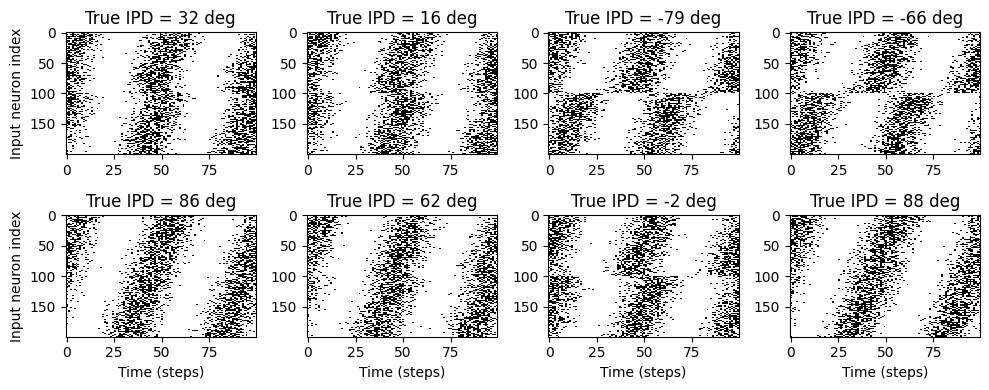

In [ ]:

second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms
anf_per_ear = 100
envelope_power = 2
rate_max = 600*Hz
f = 20*Hz
duration = .1*second
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand())
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)

    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]

    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot
ipd, spikes = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].cpu().numpy().T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

In [ ]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long()

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


In [ ]:
# Weights and uniform weight initialisation
def init_weight_matrix():

    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

# Run the simulation
def membrane_only(input_spikes, W, tau=20*ms):
    # Input has shape (batch_size, duration_steps, input_size)
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b
    h = torch.einsum("abc,cd->abd", (input_spikes, W))

    alpha = 1 - dt / tau

    # Update membrane and spikes one time step at a time
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

### Training

We train this by dividing the input data into batches and computing gradients across batches. In this notebook, batch and data size is small so that it can be run on a laptop in a couple of minutes, but normally you'd use larger batches and more data. Let's start with the data.

In [ ]:
# Parameters for training.
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# randomly permute
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

Now we run the training. We generate the training data, initialise the weight matrix, set the training parameters, and run for a few epochs, printing the training loss as we go. We use the all-powerful Adam optimiser, softmax and negative log likelihood loss.


Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=4.88392
Epoch 2: loss=3.13887
Epoch 3: loss=2.70879
Epoch 4: loss=2.46039
Epoch 5: loss=2.33489
Epoch 6: loss=2.18654
Epoch 7: loss=2.12807
Epoch 8: loss=2.04469
Epoch 9: loss=1.94963
Epoch 10: loss=1.77330


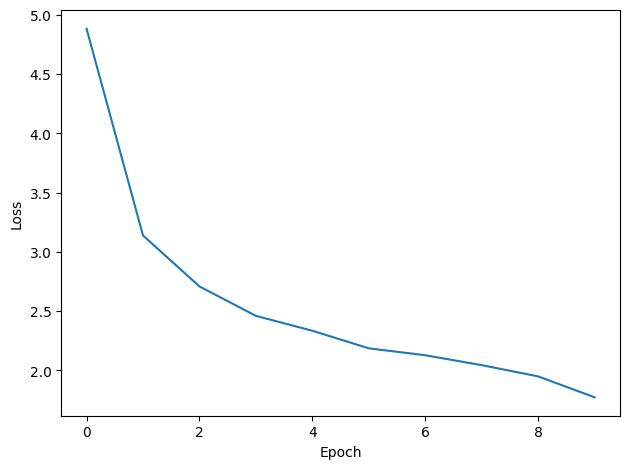

In [ ]:
# Training parameters
nb_epochs = 10
lr = 0.01

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrix
W = init_weight_matrix()

# Optimiser and loss function.
optimizer = torch.optim.Adam([W], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):

        output = membrane_only(x_local, W)

        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01
        loss = loss_fn(log_softmax_fn(m), y_local)
        local_loss.append(loss.item())
        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

### Analysis of results

Now we compute the training and test accuracy, and plot histograms and confusion matrices to understand the errors it's making.


Chance accuracy level: 8.3%

Train classifier accuracy: 0.0%
Train absolute error: 16.8 deg

Test classifier accuracy: 0.0%
Test absolute error: 19.6 deg


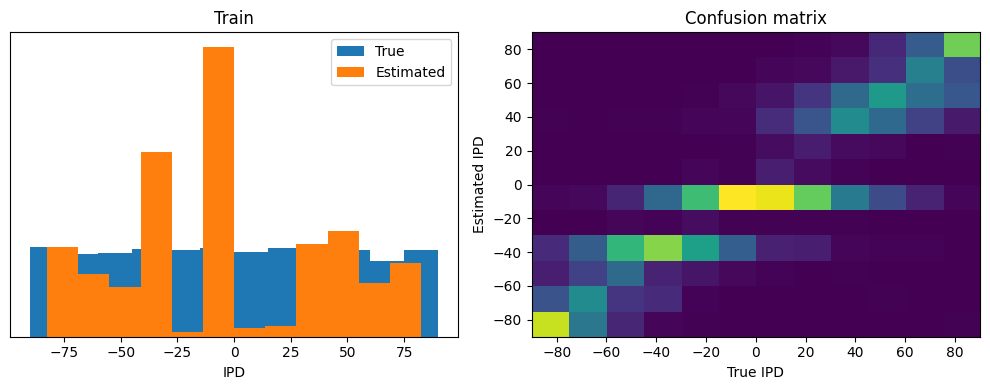

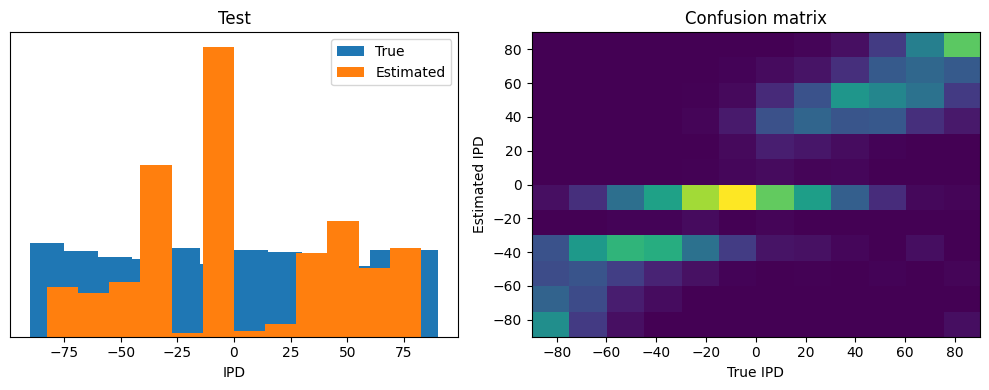

In [ ]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am.detach().cpu().numpy()))
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true - ipd_est) * 180 / np.pi
    print()
    print(f"{label} classifier accuracy: {100 * np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=num_classes, label='True')
    plt.hist(ipd_est * 180 / np.pi, bins=num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()

print(f"Chance accuracy level: {100 * 1 / num_classes:.1f}%")
run_func = lambda x: membrane_only(x, W)
analyse(ipds, spikes, 'Train', run=run_func)

# Generate testing data
ipds_test, spikes_test = random_ipd_input_signal(n_testing_batches * batch_size)

# Evaluate the classifier on the testing data
run_func = lambda x: membrane_only(x, W)
analyse(ipds_test, spikes_test, 'Test', run=run_func)


This poor performance isn't surprising because this network is not actually doing any coincidence detection, just a weighted sum of input spikes.

## Spiking model

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.
\

### Surrogate gradient descent

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.



In [ ]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        sigmoid_derivative = torch.sigmoid(input) * (1 - torch.sigmoid(input))
        grad = grad_output * sigmoid_derivative
        return grad

spike_fn = SurrGradSpike.apply


### Updated model

The code for the updated model is very similar to the membrane only layer. First, for initialisation we now need two weight matrices, $W_1$ from the input to the hidden layer, and $W_2$ from the hidden layer to the output layer. Second, we run two passes of the loop that you saw above for the membrane only model.

The first pass computes the output spikes of the hidden layer. The second pass computes the output layer and is exactly the same as before except using the spikes from the hidden layer instead of the input layer.

For the first pass, we modify the function in two ways.

Firstly, we compute the spikes with the line ``s = spike_fn(v-1)``. In the forward pass this just computes the Heaviside function of $v-1$, i.e. returns 1 if $v>1$, otherwise 0, which is the spike threshold function for the LIF neuron. In the backwards pass, it returns a gradient of the smoothed version of the Heaviside function.

The other line we change is the membrane potential update line. Now, we multiply by $1-s$ where ($s=1$ if there was a spike in the previous time step, otherwise $s=0$), so that the membrane potential is reset to 0 after a spike (but in a differentiable way rather than just setting it to 0).


In [ ]:
num_hidden = 30
tau = 2*ms

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms):
    # First layer: input to hidden
    v1 = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s1 = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec1 = [s1]
    h1 = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha1 = np.exp(-dt/tau)

    for t in range(duration_steps - 1):
        new_v1 = (alpha1*v1 + h1[:, t, :]) * (1 - s1)  # multiply by 0 after a spike
        s1 = spike_fn(v1 - 1)  # threshold of 1
        v1 = new_v1
        s_rec1.append(s1)

    s_rec1 = torch.stack(s_rec1, dim=1)

    # Second layer: hidden to output
    v2 = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s2 = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s_rec2 = [s2]
    h2 = torch.einsum("abc,cd->abd", (s_rec1, W2))
    alpha2 = np.exp(-dt/tau)

    for t in range(duration_steps - 1):
        new_v2 = (alpha2*v2 + h2[:, t, :]) * (1 - s2)  # multiply by 0 after a spike
        s2 = spike_fn(v2 - 1)  # threshold of 1
        v2 = new_v2
        s_rec2.append(s2)

    s_rec2 = torch.stack(s_rec2, dim=1)

    # Return recorded membrane potential of output
    v_rec = s_rec2
    return v_rec


### Training and analysing




Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=2.48808
Epoch 2: loss=2.48808
Epoch 3: loss=2.48808
Epoch 4: loss=2.48808
Epoch 5: loss=2.48808
Epoch 6: loss=2.48808
Epoch 7: loss=2.48808
Epoch 8: loss=2.48808
Epoch 9: loss=2.48808
Epoch 10: loss=2.48808


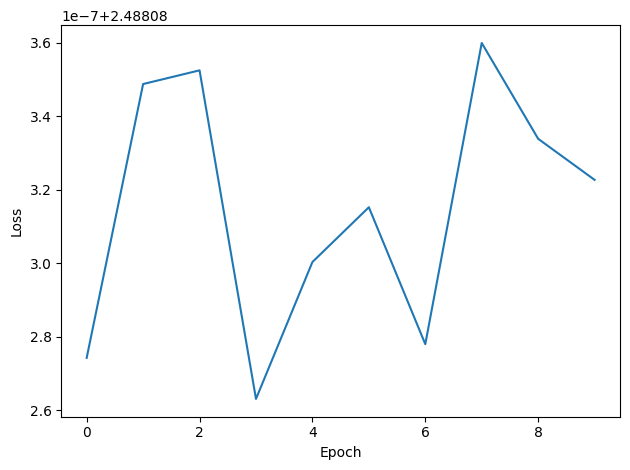

In [ ]:
# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

optimizer_W1 = torch.optim.Adam([W1], lr=lr)
optimizer_W2 = torch.optim.Adam([W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()


print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        # Run network
        output = snn(x_local, W1, W2)
        # Compute cross entropy loss
        m = torch.sum(output, 1)*0.01  # Sum time dimension
        loss = loss_fn(log_softmax_fn(m), y_local)
        local_loss.append(loss.item())
        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Chance accuracy level: 8.3%

Train classifier accuracy: 0.0%
Train absolute error: 55.0 deg

Test classifier accuracy: 0.0%
Test absolute error: 55.8 deg


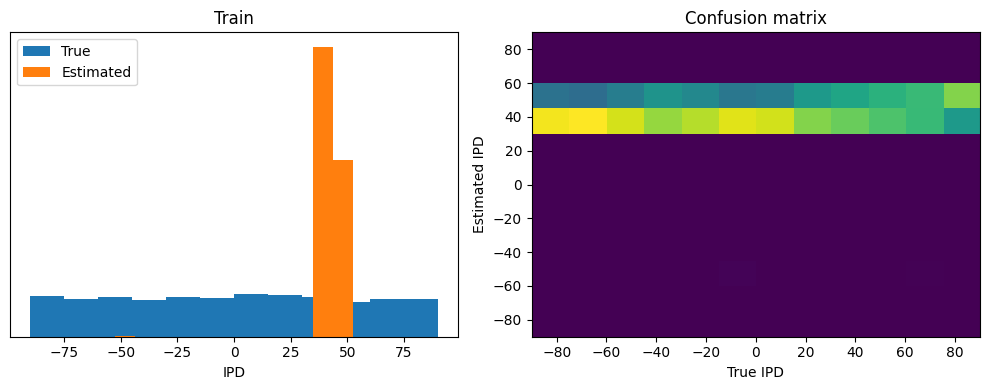

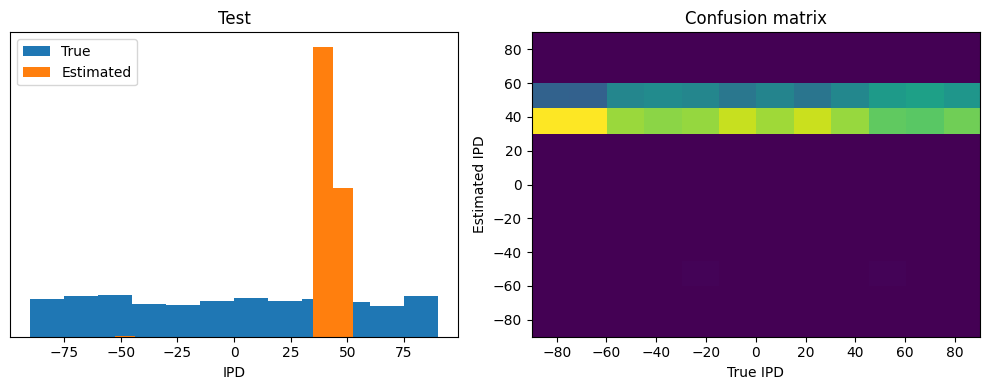

In [ ]:
# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

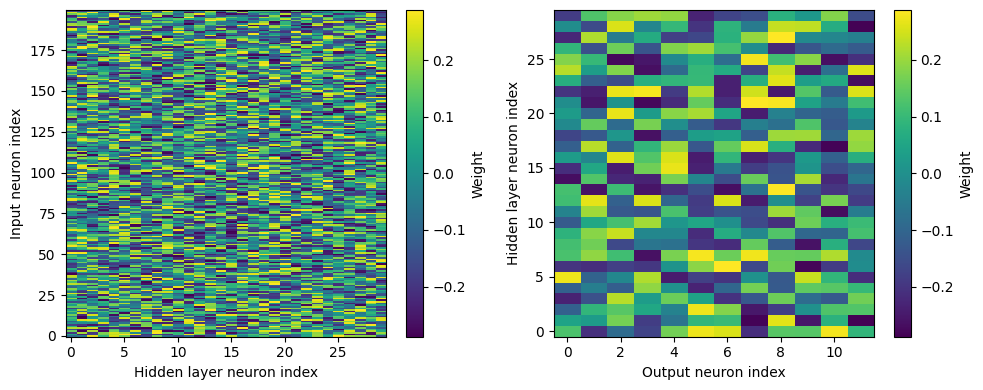

In [ ]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

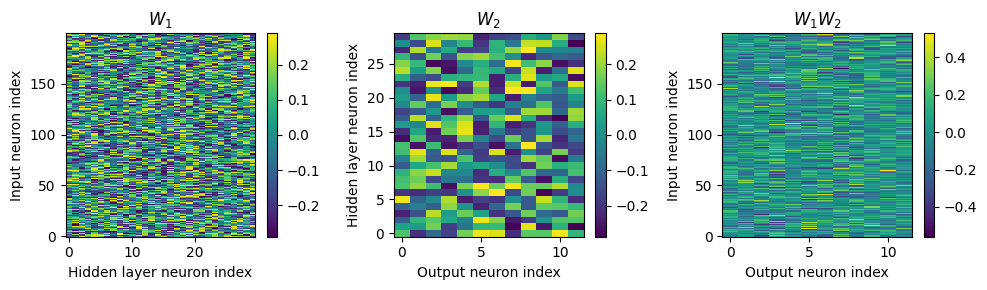

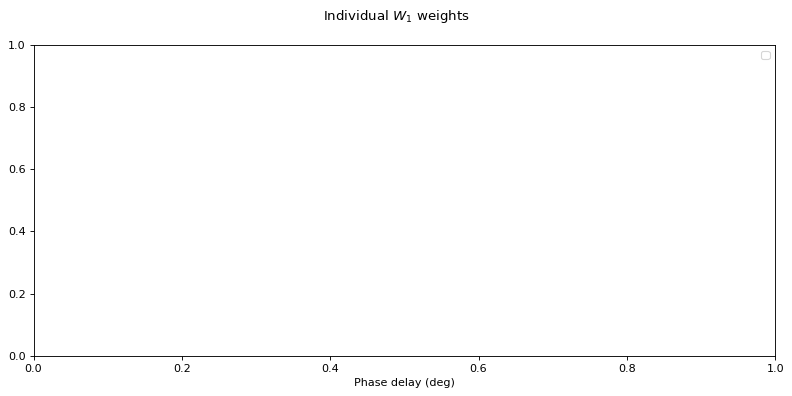

In [ ]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
#A = np.arange(w1.shape[0])[:, None]
A = np.hstack([np.arange(anf_per_ear), -np.arange(anf_per_ear)])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in enumerate(I_nz):
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

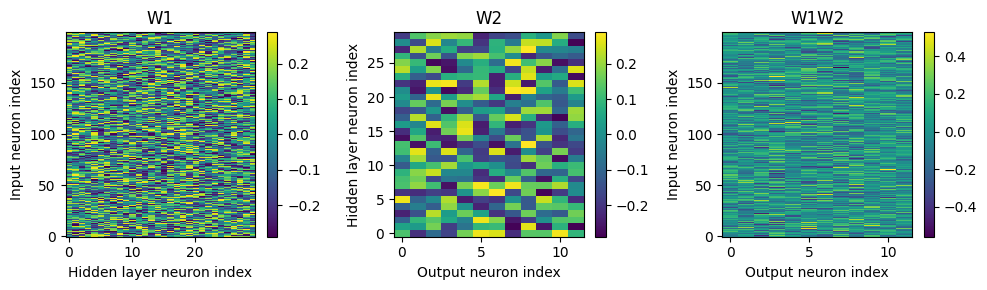

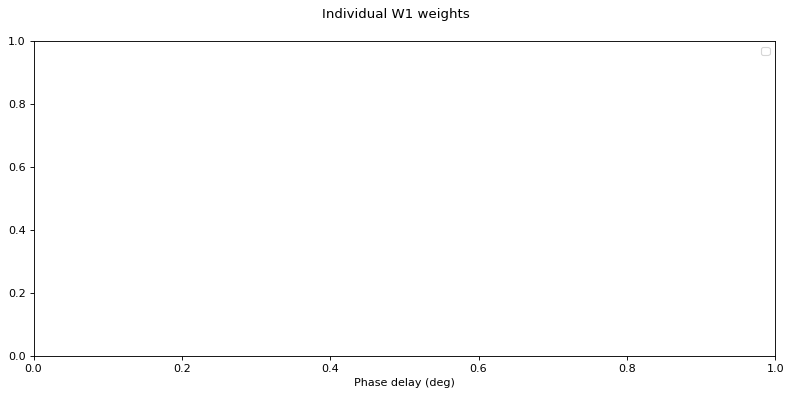

In [ ]:
# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('W1')  # Use plain text title
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('W2')  # Use plain text title
plt.colorbar()
plt.subplot(133)
plt.imshow(w1 @ w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('W1W2')  # Use plain text title
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0) > 0.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in enumerate(I_nz):
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual W1 weights")  # Use plain text title
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()
